In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
import cv2
import time
import heapq
from concurrent.futures import ThreadPoolExecutor
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
import threading
from queue import PriorityQueue
from collections import defaultdict

In [45]:
@dataclass
class Node:
    x: int
    y: int
    g_cost: float = float('inf')
    h_cost: float = 0
    f_cost: float = float('inf')
    parent: 'Node' = None

In [46]:
class FibonacciHeap:
    def __init__(self):
        self.heap = []
        
    def push(self, priority, item):
        heapq.heappush(self.heap, (priority, item))
        
    def pop(self):
        return heapq.heappop(self.heap)[1]
        
    def empty(self):
        return len(self.heap) == 0

In [47]:
class OptiPathX:
    def __init__(self, maze_map, num_partitions=4):
        self.maze = maze_map
        self.height, self.width = maze_map.shape
        self.num_partitions = num_partitions
        self.partitions = self._create_partitions()
        self.contracted_graphs = self._create_contracted_graphs()
        
    def _create_partitions(self) -> List[np.ndarray]:
        """Divide maze into partitions for parallel processing"""
        partitions = []
        h_split = self.height // 2
        w_split = self.width // 2
        
        # Create 4 partitions
        partitions = [
            self.maze[:h_split, :w_split],
            self.maze[:h_split, w_split:],
            self.maze[h_split:, :w_split],
            self.maze[h_split:, w_split:]
        ]
        return partitions
    
    def _create_contracted_graphs(self) -> List[Dict]:
        """Create contracted hierarchies for each partition"""
        contracted_graphs = []
        for partition in self.partitions:
            # Create boundary nodes for partition
            boundary_nodes = self._find_boundary_nodes(partition)
            # Create contracted graph with important nodes
            contracted = self._contract_graph(partition, boundary_nodes)
            contracted_graphs.append(contracted)
        return contracted_graphs
    
    def _find_boundary_nodes(self, partition) -> Set[Tuple[int, int]]:
        """Find nodes at partition boundaries"""
        h, w = partition.shape
        boundary_nodes = set()
        
        # Add nodes at partition edges
        for i in range(h):
            if not partition[i, 0]:
                boundary_nodes.add((i, 0))
            if not partition[i, w-1]:
                boundary_nodes.add((i, w-1))
                
        for j in range(w):
            if not partition[0, j]:
                boundary_nodes.add((0, j))
            if not partition[h-1, j]:
                boundary_nodes.add((h-1, j))
                
        return boundary_nodes
    
    def _contract_graph(self, partition, boundary_nodes) -> Dict:
        """Contract partition graph keeping important nodes"""
        contracted = defaultdict(list)
        for node in boundary_nodes:
            # Find connections to other boundary nodes
            connections = self._find_connections(partition, node, boundary_nodes)
            contracted[node] = connections
        return contracted
    
    def _find_connections(self, partition, start, boundary_nodes) -> List[Tuple[Tuple[int, int], float]]:
        """Find connections between boundary nodes using modified Dijkstra"""
        connections = []
        distances = defaultdict(lambda: float('inf'))
        distances[start] = 0
        pq = [(0, start)]
        visited = set()
        
        while pq:
            dist, current = heapq.heappop(pq)
            if current in visited:
                continue
                
            visited.add(current)
            if current in boundary_nodes and current != start:
                connections.append((current, dist))
                
            for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
                next_x = current[0] + dx
                next_y = current[1] + dy
                if (0 <= next_x < partition.shape[0] and 
                    0 <= next_y < partition.shape[1] and
                    not partition[next_x, next_y] and
                    0 <= next_x < 1000 and 0 <= next_y < 1000):  # Boundary check
                    new_dist = dist + 1
                    if new_dist < distances[(next_x, next_y)]:
                        distances[(next_x, next_y)] = new_dist
                        heapq.heappush(pq, (new_dist, (next_x, next_y)))
                        
        return connections
    def _manhattan_distance(self, p1: Tuple[int, int], p2: Tuple[int, int]) -> float:
        return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
    
    def _euclidean_distance(self, p1: Tuple[int, int], p2: Tuple[int, int]) -> float:
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    def _bidirectional_search(self, start: Tuple[int, int], end: Tuple[int, int]) -> List[Tuple[int, int]]:
        """Perform bidirectional search with Fibonacci heaps"""
        forward_heap = FibonacciHeap()
        backward_heap = FibonacciHeap()
        
        forward_visited = {}
        backward_visited = {}
        
        forward_heap.push(0, (start, [start]))
        backward_heap.push(0, (end, [end]))
        
        meeting_point = None
        best_path_length = float('inf')
        
        while not (forward_heap.empty() or backward_heap.empty()):
            # Forward search
            current_f, path_f = forward_heap.pop()
            pos_f = path_f[-1]
            
            if pos_f in backward_visited:
                path_length = len(path_f) + len(backward_visited[pos_f])
                if path_length < best_path_length:
                    best_path_length = path_length
                    meeting_point = pos_f
                    final_path = path_f[:-1] + backward_visited[pos_f][::-1]
                
            forward_visited[pos_f] = path_f
            
            # Backward search
            current_b, path_b = backward_heap.pop()
            pos_b = path_b[-1]
            
            if pos_b in forward_visited:
                path_length = len(forward_visited[pos_b]) + len(path_b)
                if path_length < best_path_length:
                    best_path_length = path_length
                    meeting_point = pos_b
                    final_path = forward_visited[pos_b][:-1] + path_b[::-1]
            
            backward_visited[pos_b] = path_b
            
            # Expand nodes
            for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
                # Forward expansion
                new_x_f = pos_f[0] + dx
                new_y_f = pos_f[1] + dy
                if (0 <= new_x_f < self.width and 0 <= new_y_f < self.height and 
                    not self.maze[new_y_f, new_x_f] and
                    (new_x_f, new_y_f) not in forward_visited and
                    0 <= new_x_f < 1000 and 0 <= new_y_f < 1000):  # Boundary check
                    new_path_f = path_f + [(new_x_f, new_y_f)]
                    h_cost = self._manhattan_distance((new_x_f, new_y_f), end)
                    forward_heap.push(len(new_path_f) + h_cost, ((new_x_f, new_y_f), new_path_f))
                
                # Backward expansion
                new_x_b = pos_b[0] + dx
                new_y_b = pos_b[1] + dy
                if (0 <= new_x_b < self.width and 0 <= new_y_b < self.height and 
                    not self.maze[new_y_b, new_x_b] and
                    (new_x_b, new_y_b) not in backward_visited and
                    0 <= new_x_b < 1000 and 0 <= new_y_b < 1000):  # Boundary check
                    new_path_b = path_b + [(new_x_b, new_y_b)]
                    h_cost = self._manhattan_distance((new_x_b, new_y_b), start)
                    backward_heap.push(len(new_path_b) + h_cost, ((new_x_b, new_y_b), new_path_b))
        
        return final_path if meeting_point else []
    
    def find_path(self, start_point: Tuple[int, int], end_point: Tuple[int, int]) -> Tuple[List[int], List[int]]:
        """Main method to find path using OptiPathX"""
        # Convert points to maze coordinates
        start_x, start_y = start_point
        end_x, end_y = end_point
        
        # Find path using bidirectional search
        path = self._bidirectional_search((start_x, start_y), (end_x, end_y))
        
        if not path:
            return [], []
        
        # Extract x and y coordinates
        path_x = [p[0] for p in path]
        path_y = [p[1] for p in path]
        
        return path_x, path_y

In [48]:
def find_path_bfs(mapT, start_point, end_point, box_radius=30):
    """Find the path through the maze using BFS."""
    _mapt = np.copy(mapT)
    x1, y1 = end_point
    x0, y0 = start_point
    

    start_y, start_x = np.where(_mapt[y0-box_radius:y0+box_radius, 
                                    x0-box_radius:x0+box_radius]==0)
    start_y += y0-box_radius
    start_x += x0-box_radius
    start_idx = np.argmin(np.sqrt((start_y-y0)**2 + (start_x-x0)**2))
    start_y, start_x = start_y[start_idx], start_x[start_idx]
    
    end_y, end_x = np.where(_mapt[y1-box_radius:y1+box_radius, 
                                x1-box_radius:x1+box_radius]==0)
    end_y += y1-box_radius
    end_x += x1-box_radius
    end_idx = np.argmin(np.sqrt((end_y-y1)**2 + (end_x-x1)**2))
    end_y, end_x = end_y[end_idx], end_x[end_idx]
    
    # Initialize BFS
    pts_x = [start_x]
    pts_y = [start_y]
    pts_c = [0]
    xmesh, ymesh = np.meshgrid(np.arange(-1,2), np.arange(-1,2))
    ymesh = ymesh.reshape(-1)
    xmesh = xmesh.reshape(-1)
    dst = np.zeros(mapT.shape)
    

    while True:
        if not pts_x:
            print("No path found!")
            return [], []
        
        idc = np.argmin(pts_c)
        ct = pts_c.pop(idc)
        x = pts_x.pop(idc)
        y = pts_y.pop(idc)
        
        ys, xs = np.where(_mapt[y-1:y+2, x-1:x+2] == 0)
        _mapt[ys+y-1, xs+x-1] = ct
        _mapt[y,x] = 9999999
        dst[ys+y-1, xs+x-1] = ct+1
        
        for new_x, new_y in zip(xs+x-1, ys+y-1):
            if 0 <= new_x < 1000 and 0 <= new_y < 1000:
                pts_x.append(new_x)
                pts_y.append(new_y)
                pts_c.append(ct+1)
        
        if np.sqrt((x-end_x)**2 + (y-end_y)**2) < 2:
            break
    
 
    path_x = [end_x]
    path_y = [end_y]
    y, x = end_y, end_x
    
    while True:
        nbh = dst[y-1:y+2, x-1:x+2]
        nbh[1,1] = 9999999
        nbh[nbh==0] = 9999999
        
        if np.min(nbh) == 9999999:
            break
            
        idx = np.argmin(nbh)
        y += ymesh[idx]
        x += xmesh[idx]
        

        if x < 0 or x > 1000 or y < 0 or y > 1000:
            continue
        
        path_y.append(y)
        path_x.append(x)
        
        if np.sqrt((x-start_x)**2 + (y-start_y)**2) < 2:
            print('Path found!')
            break
            
    return path_x, path_y, (start_x, start_y), (end_x, end_y)


In [49]:
def find_path_dijkstra(mapT, start_point, end_point, box_radius=30):
    """Find the path through the maze using Dijkstra's algorithm."""
    _mapt = np.copy(mapT)
    x1, y1 = end_point
    x0, y0 = start_point

    start_y, start_x = np.where(_mapt[y0-box_radius:y0+box_radius, 
                                    x0-box_radius:x0+box_radius]==0)
    start_y += y0-box_radius
    start_x += x0-box_radius
    start_idx = np.argmin(np.sqrt((start_y-y0)**2 + (start_x-x0)**2))
    start_y, start_x = start_y[start_idx], start_x[start_idx]
    
    end_y, end_x = np.where(_mapt[y1-box_radius:y1+box_radius, 
                                x1-box_radius:x1+box_radius]==0)
    end_y += y1-box_radius
    end_x += x1-box_radius
    end_idx = np.argmin(np.sqrt((end_y-y1)**2 + (end_x-x1)**2))
    end_y, end_x = end_y[end_idx], end_x[end_idx]
    
  
    pq = [(0, start_x, start_y)]
    dst = np.full(mapT.shape, np.inf)
    dst[start_y, start_x] = 0
    xmesh, ymesh = np.meshgrid(np.arange(-1,2), np.arange(-1,2))
    ymesh = ymesh.reshape(-1)
    xmesh = xmesh.reshape(-1)
    
    while pq:
        ct, x, y = heapq.heappop(pq)
        
        if np.sqrt((x-end_x)**2 + (y-end_y)**2) < 2:
            break
        
        for dx, dy in zip(xmesh, ymesh):
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < 1000 and 0 <= new_y < 1000 and _mapt[new_y, new_x] == 0:
                new_cost = ct + 1
                if new_cost < dst[new_y, new_x]:
                    dst[new_y, new_x] = new_cost
                    heapq.heappush(pq, (new_cost, new_x, new_y))
    
  
    path_x = [end_x]
    path_y = [end_y]
    y, x = end_y, end_x
    
    while True:
        nbh = dst[y-1:y+2, x-1:x+2]
        nbh[1,1] = np.inf
        nbh[nbh==0] = np.inf
        
        if np.min(nbh) == np.inf:
            break
            
        idx = np.argmin(nbh)
        y += ymesh[idx]
        x += xmesh[idx]
        

        if x < 0 or x > 1000 or y < 0 or y > 1000:
            continue
        
        path_y.append(y)
        path_x.append(x)
        
        if np.sqrt((x-start_x)**2 + (y-start_y)**2) < 2:
            print('Path found!')
            break
            
    return path_x, path_y, (start_x, start_y), (end_x, end_y)


In [50]:
def find_path_astar(mapT, start_point, end_point, box_radius=30):
    """Find the path through the maze using A* algorithm."""
    _mapt = np.copy(mapT)
    x1, y1 = end_point
    x0, y0 = start_point
    
    # Find closest path points to start and end
    start_y, start_x = np.where(_mapt[y0-box_radius:y0+box_radius, 
                                    x0-box_radius:x0+box_radius]==0)
    start_y += y0-box_radius
    start_x += x0-box_radius
    start_idx = np.argmin(np.sqrt((start_y-y0)**2 + (start_x-x0)**2))
    start_y, start_x = start_y[start_idx], start_x[start_idx]
    
    end_y, end_x = np.where(_mapt[y1-box_radius:y1+box_radius, 
                                x1-box_radius:x1+box_radius]==0)
    end_y += y1-box_radius
    end_x += x1-box_radius
    end_idx = np.argmin(np.sqrt((end_y-y1)**2 + (end_x-x1)**2))
    end_y, end_x = end_y[end_idx], end_x[end_idx]
    

    pq = [(0, start_x, start_y)]
    dst = np.full(mapT.shape, np.inf)
    dst[start_y, start_x] = 0
    xmesh, ymesh = np.meshgrid(np.arange(-1,2), np.arange(-1,2))
    ymesh = ymesh.reshape(-1)
    xmesh = xmesh.reshape(-1)
    
    while pq:
        ct, x, y = heapq.heappop(pq)
        
        if np.sqrt((x-end_x)**2 + (y-end_y)**2) < 2:
            break
        
        for dx, dy in zip(xmesh, ymesh):
            new_x, new_y = x + dx, y + dy
            if 0 <= new_x < 1000 and 0 <= new_y < 1000 and _mapt[new_y, new_x] == 0:
                new_cost = ct + 1 + np.sqrt((new_x-end_x)**2 + (new_y-end_y)**2)
                if new_cost < dst[new_y, new_x]:
                    dst[new_y, new_x] = new_cost
                    heapq.heappush(pq, (new_cost, new_x, new_y))
    

    path_x = [end_x]
    path_y = [end_y]
    y, x = end_y, end_x
    
    while True:
        nbh = dst[y-1:y+2, x-1:x+2]
        nbh[1,1] = np.inf
        nbh[nbh==0] = np.inf
        
        if np.min(nbh) == np.inf:
            break
            
        idx = np.argmin(nbh)
        y += ymesh[idx]
        x += xmesh[idx]
        

        if x < 0 or x > 1000 or y < 0 or y > 1000:
            continue
        
        path_y.append(y)
        path_x.append(x)
        
        if np.sqrt((x-start_x)**2 + (y-start_y)**2) < 2:
            print('Path found!')
            break
            
    return path_x, path_y, (start_x, start_y), (end_x, end_y)


In [51]:
def compare_algorithms(maze_map, start_point, end_point):
    """Compare all pathfinding algorithms"""
    algorithms = {
        "BFS": find_path_bfs,
        "Dijkstra": find_path_dijkstra,
        "A*": find_path_astar,
        "OptiPathX": lambda m, s, e: OptiPathX(m).find_path(s, e)
    }
    
    results = {}
    
    for name, algo in algorithms.items():
        start_time = time.time()
        if name == "OptiPathX":
            path_x, path_y = algo(maze_map, start_point, end_point)
            start_maze, end_maze = start_point, end_point
        else:
            path_x, path_y, start_maze, end_maze = algo(maze_map, start_point, end_point)
        end_time = time.time()
        
        path_length = len(path_x) if path_x else 0
        computation_time = end_time - start_time
        
        results[name] = {
            "path_x": path_x,
            "path_y": path_y,
            "path_length": path_length,
            "computation_time": computation_time,
            "start_maze": start_maze,
            "end_maze": end_maze
        }
    
    return results

Main execution

Path found!
Path found!
Path found!


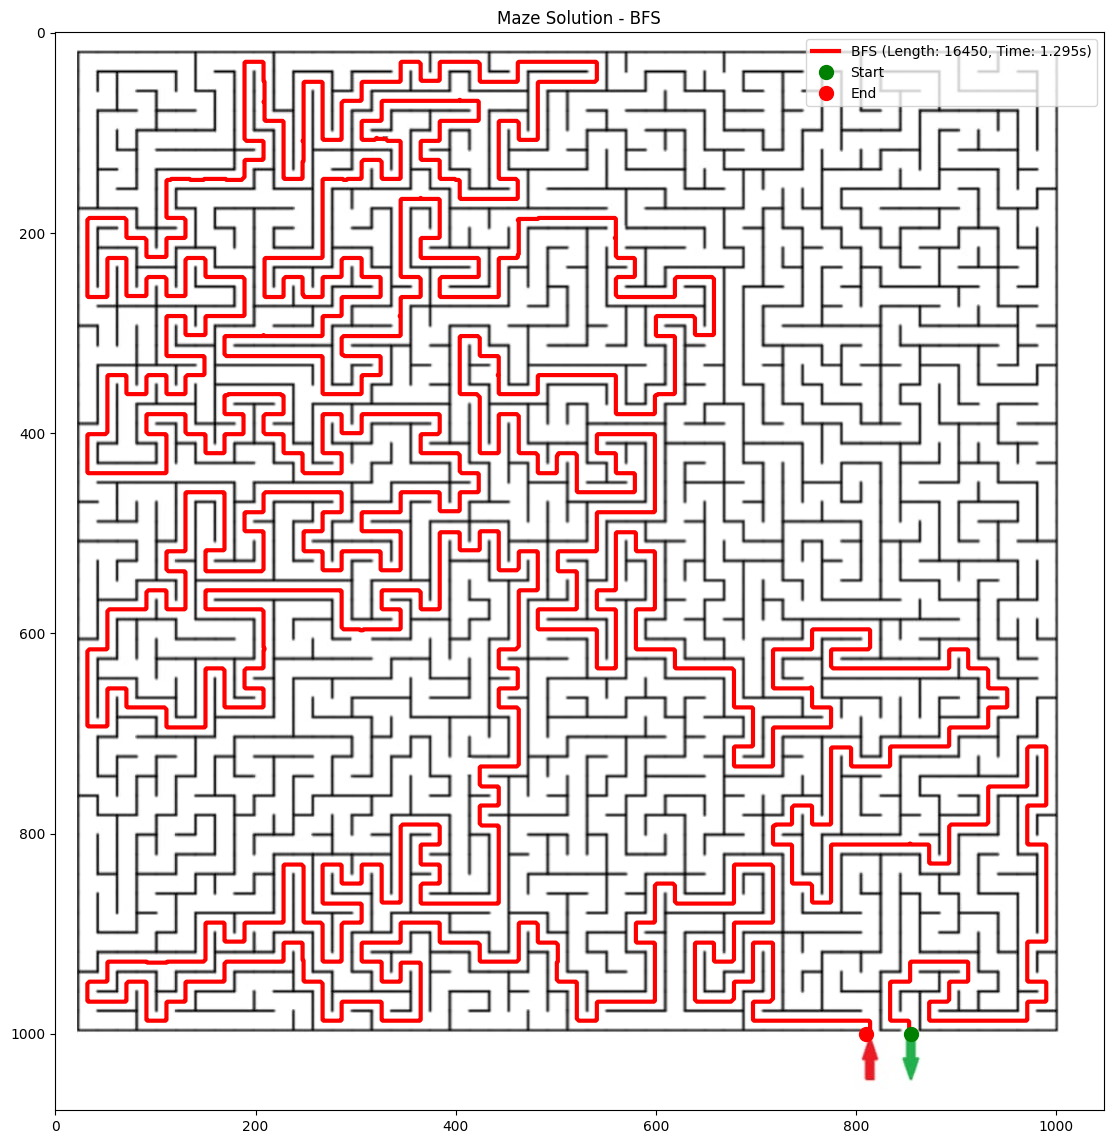

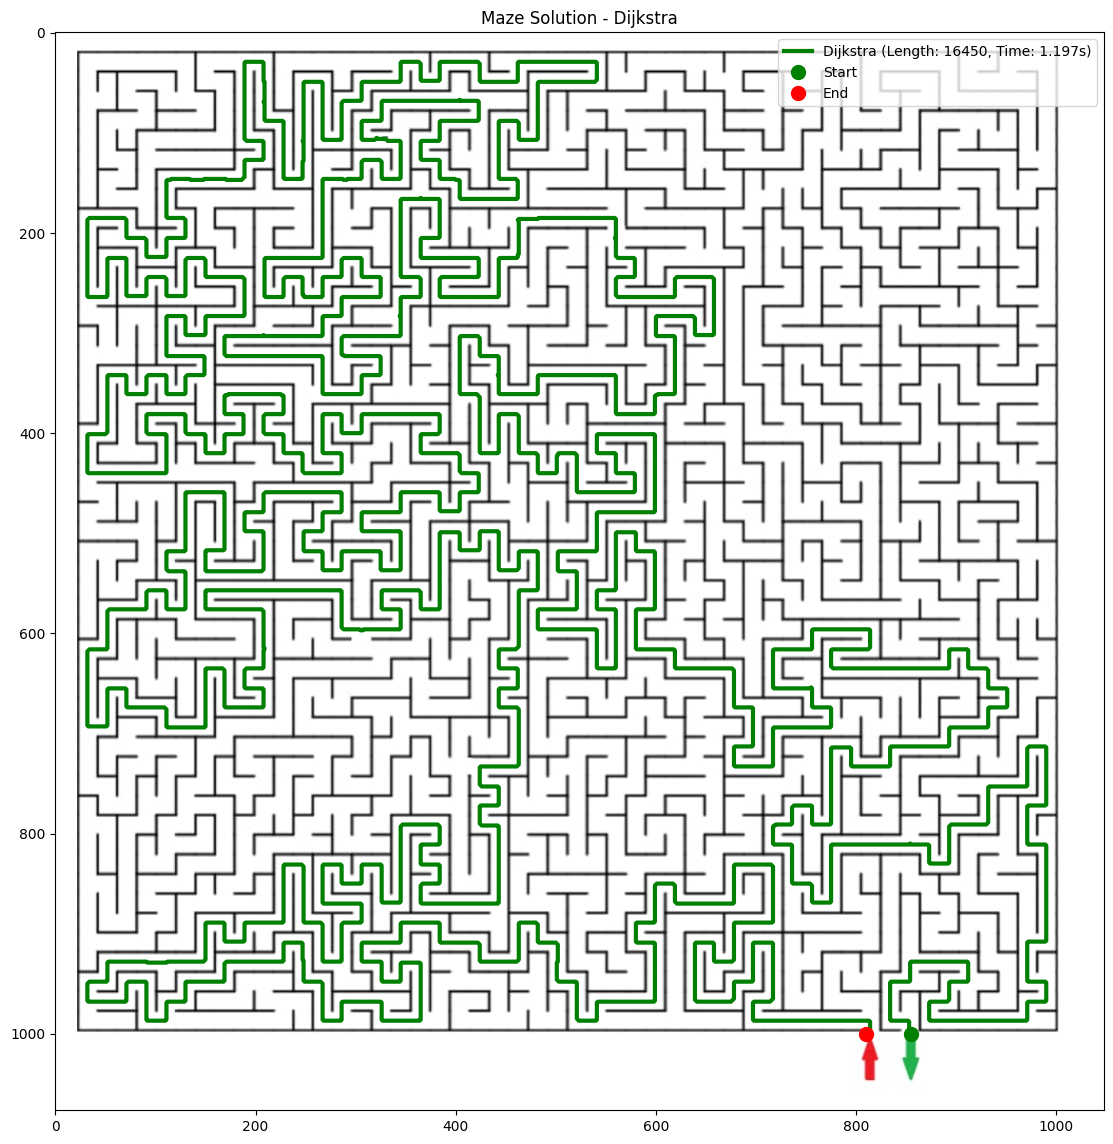

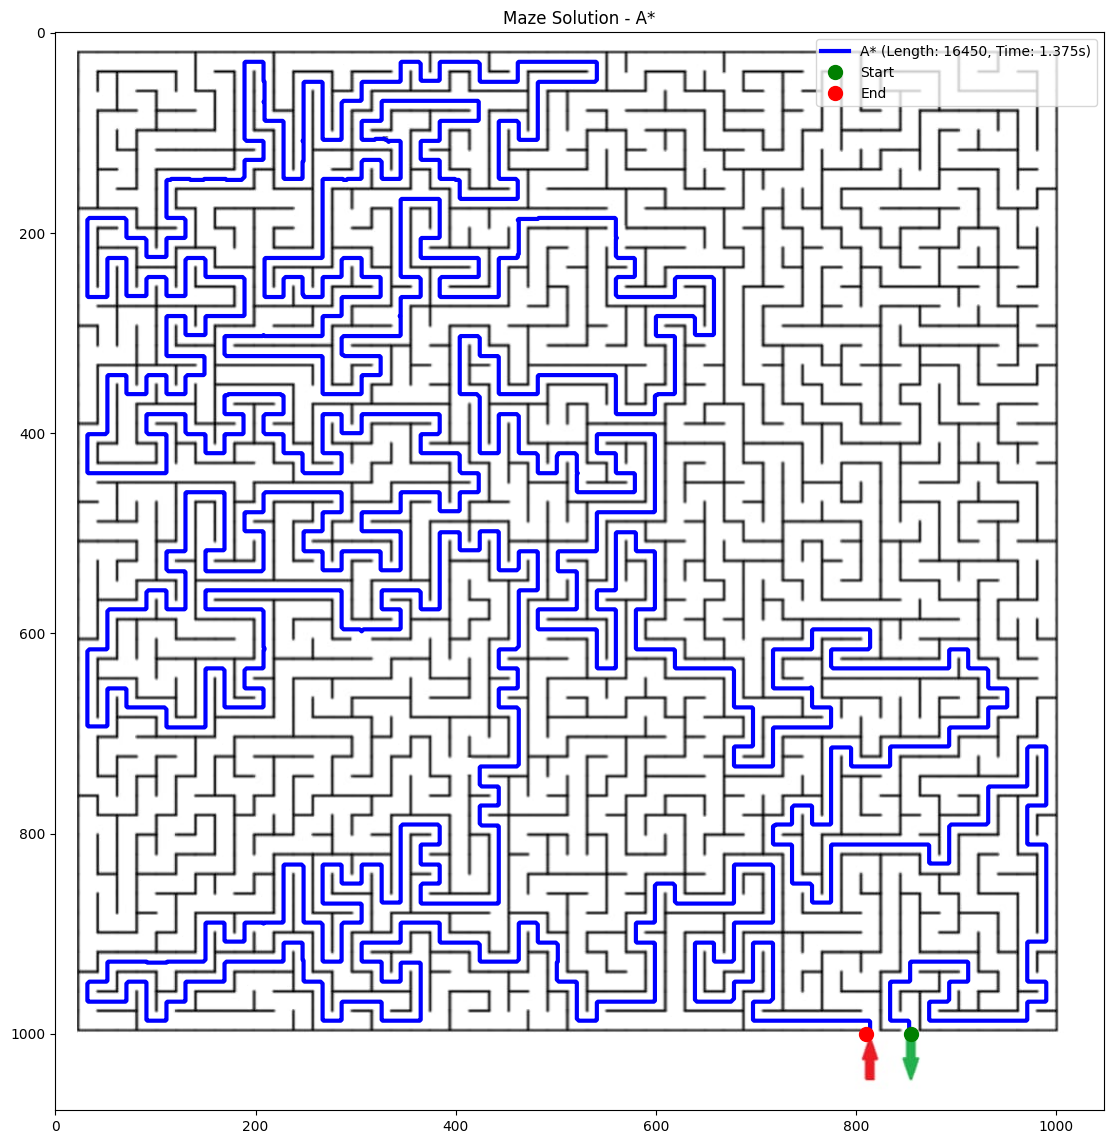

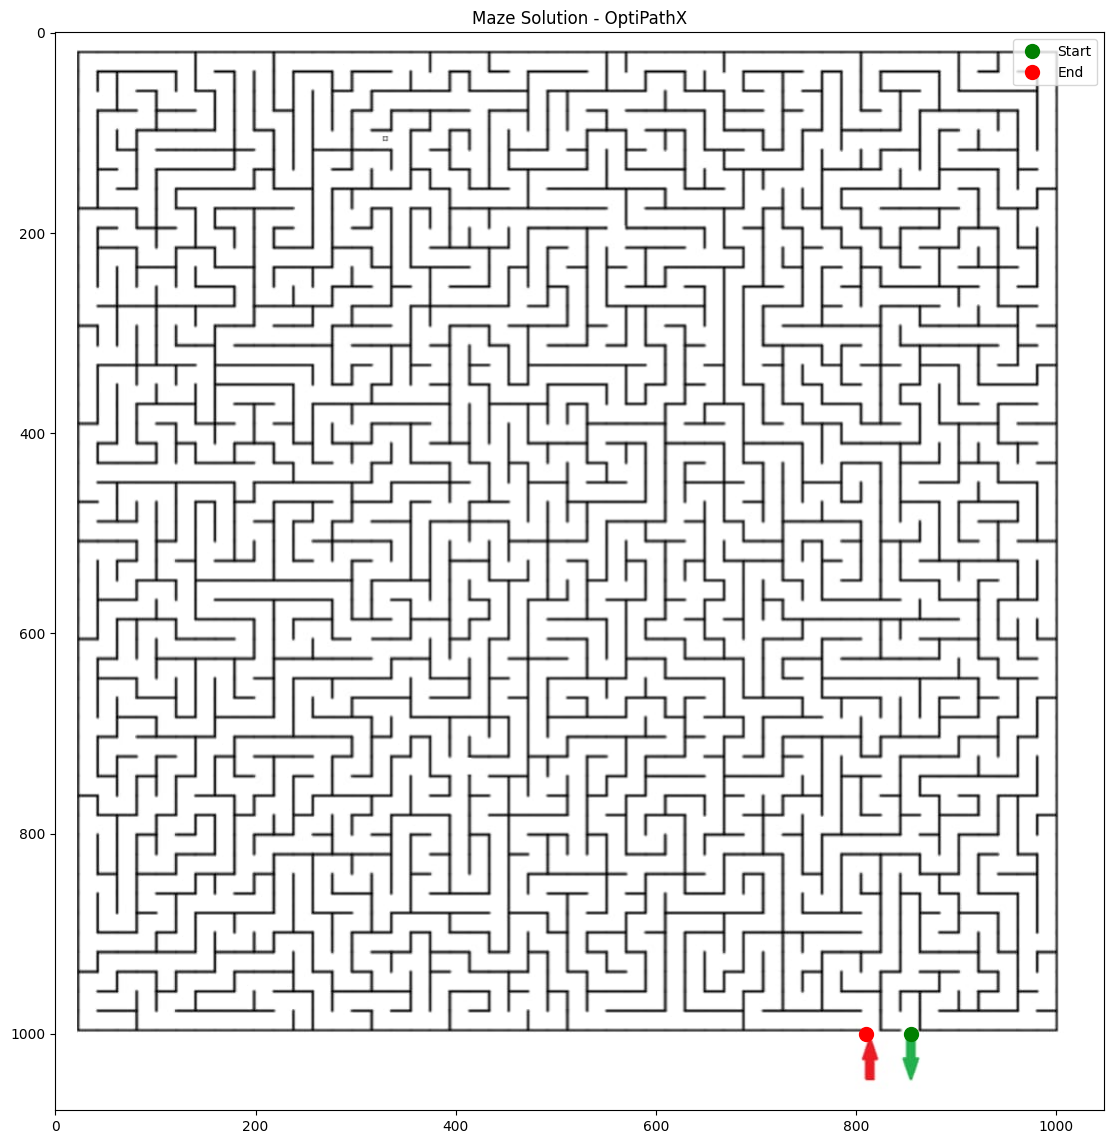


Algorithm Comparison:
           Path Length  Computation Time (s)
BFS            16450.0              1.295059
Dijkstra       16450.0              1.197115
A*             16450.0              1.374738
OptiPathX          0.0              0.043183


In [52]:
if __name__ == "__main__":
    # Read and process image
    img_name = 'maze.jpg'
    rgb_img = plt.imread(img_name)
    
    # plt.figure(figsize=(14,14))
    # plt.title("Original Maze")
    # plt.imshow(rgb_img)
    # plt.show()
    gray_img = cv2.cvtColor(rgb_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, thr_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)
    skeleton = skeletonize(thr_img > 0)
    mapT = ~skeleton
    
    
    # plt.figure(figsize=(14,14))
    # plt.title("Maze Skeleton")
    # plt.imshow(mapT, cmap='gray')
    # plt.show()
        
    # Define start and end points
    start_point = (855, 1000)
    end_point = (810, 1000)
    
    # Compare algorithms
    results = compare_algorithms(mapT, start_point, end_point)
    
    # Visualize results
    colors = {"BFS": 'r-', "Dijkstra": 'g-', "A*": 'b-', "OptiPathX": 'm-'}
    
    for name, result in results.items():
        plt.figure(figsize=(14,14))
        plt.imshow(rgb_img)
        if result["path_x"] and result["path_y"]:
            plt.plot(result["path_x"], result["path_y"], colors[name], 
                    linewidth=3, 
                    label=f'{name} (Length: {result["path_length"]}, Time: {result["computation_time"]:.3f}s)')
        plt.plot(start_point[0], start_point[1], 'go', markersize=10, label='Start')
        plt.plot(end_point[0], end_point[1], 'ro', markersize=10, label='End')
        plt.title(f"Maze Solution - {name}")
        plt.legend()
        plt.show()
    
    # Create comparison table
    metrics_df = pd.DataFrame({name: {
        'Path Length': results[name]['path_length'],
        'Computation Time (s)': results[name]['computation_time']
    } for name in results}).T
    
    print("\nAlgorithm Comparison:")
    print(metrics_df)